In [10]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from sklearn.manifold import TSNE
import plotly.express as px
import pooch #for data
import tempfile
import muon #for data 
from torch.utils.data import DataLoader, TensorDataset
import importlib
import vae_class


from sklearn.cluster import KMeans

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

acquiring pbmc 5k data

In [4]:
#downloading data
save_dir = tempfile.TemporaryDirectory()
def download_data(save_path: str, url:str, fname: str, known_hash:str) -> str:
    return pooch.retrieve(
        url=url,
        known_hash=known_hash,
        fname=fname,
        path=save_path,
    )

h5_path = download_data(save_path=save_dir.name, 
                        fname = "pbmc5k_protein_filtered_feature_bc_matrix.h5",
                        known_hash='7695e6b1888bdae6f53b3a28a99f0a0cdf387d1685e330a597cdd4b5541f8abd',
                        url = "https://cf.10xgenomics.com/samples/cell-exp/3.0.2/5k_pbmc_protein_v3/5k_pbmc_protein_v3_filtered_feature_bc_matrix.h5")
#to muon
pbmc5k = muon.read_10x_h5(h5_path)
pbmc5k.var_names_make_unique()
apbmc  = pbmc5k.to_anndata()

#extracting RNA data
pbmc5k_rna  = pbmc5k['rna']
apbmc_rna  = pbmc5k_rna.copy()

#creating a dataset
rna_df = apbmc_rna.to_df()
rna_df.head()

C:\Users\samue\anaconda3\lib\site-packages\anndata\_core\anndata.py:1760: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\samue\anaconda3\lib\site-packages\anndata\_core\anndata.py:1760: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\samue\anaconda3\lib\site-packages\mudata\_core\mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
C:\Users\samue\anaconda3\lib\site-packages\mudata\_core\mudata.py:915: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C
AAACCCAAGAGACAAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGGCCTAGA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAGTCGTGCCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCATCGTGCATA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGAAAGACAAGCC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Training vae

In [11]:
#loading data
data_5k_rna = TensorDataset(torch.tensor(apbmc_rna.X.todense(), dtype=torch.float32))
train_loader = DataLoader(data_5k_rna, batch_size=32, shuffle=True)

#importing the vae
importlib.reload(vae_class)
vae = vae_class.VAE(input_dim = apbmc_rna.X.shape[1], output_dim= apbmc_rna.X.shape[1], hidden_dim = 128, latent_dim = 10)
vae = vae.to(device)

#training the vae
optimizer = torch.optim.Adam(vae.parameters(),lr = 1e-4)
vae.train()
vae_class.training_step(model = vae, epochs = 1, train_loader = train_loader, optimizer = optimizer, device = device)
torch.save(vae, 'scvi_saved.pth')



Epoch: 1 Loss: 58045.7773


Seeing result

C:\Users\samue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


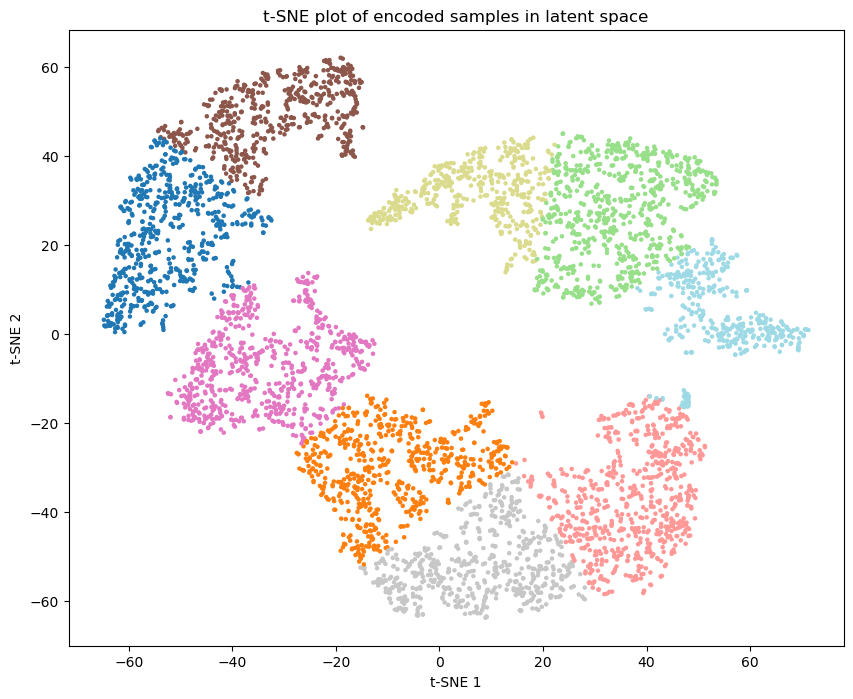

In [12]:
#encoding the data
vae = torch.load('scvi_saved.pth')
vae.eval()
encoded_samples = []
for e,(x,) in enumerate(data_5k_rna):
    x = x.to(device)
    with torch.no_grad():
        enc = vae.encoder(x.unsqueeze(0))
        z_mean  = vae.z_mean_layer(enc).numpy().squeeze()
        #z_logvar = vae.z_logvar_layer(enc).numpy()
        encoded_samples.append(z_mean)
        
#clustering with kmeans in 2D
tsne = TSNE(n_components=2)
z_tsne = tsne.fit_transform(np.array(encoded_samples))
n=9
kmeans = KMeans(n_clusters=n, random_state=0).fit(z_tsne)

#plotting
plt.figure(figsize=(10, 8))
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], s=5, c=kmeans.labels_, cmap='tab20')
plt.title('t-SNE plot of encoded samples in latent space')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()
# need to compare with the original labels

In [57]:
import scanpy as sc
import scanpy.external as sce
adata = sce.tl.zheng17()

AttributeError: module 'scanpy.external.tl' has no attribute 'zheng17'

In [55]:
adata.var_names_make_unique()
adata.obs['louvain_labels']

KeyError: 'louvain_labels'